## Adaline

We are in the same setting as we were for the perceptron. This time, however, we will be slightly more sophisticated in how we update the weights and biases of our model, in order to avoid the potential that the perceptron has to fail to converge.

Define the *loss function* $\mathcal{L}$ to be the mean-squared error between the model's prediction and the true class label, so 
$$
\mathcal{L}(\mathbf{w}, b)=\frac{1}{n}\sum_{i=1}^n\left(y^{(i)}-\sigma\left(z^{(i)}\right)\right)^2.
$$
Note that this function is not only differentiable, but also convex; thus, we can perform gradient descent to optimize the model's parameters.

Now, as before we will initialize the weights and bias, then update each iteratively as
\begin{align*}
\mathbf{w}&:=\mathbf{w}+\Delta\mathbf{w}\\
b&:=b+\Delta b
\end{align*}

However, this time the updates we use are calculated via *gradient descent* performed on the loss function given above. The idea of gradient descent is to take a step in the opposite direction of the gradient each time we update the model's weights and bias. Formally, we have
\begin{align*}
\Delta\mathbf{w}&=-\eta \nabla_{\mathbf{w}}\mathcal{L}(\mathbf{w}, b)\\
\Delta b&=-\eta \frac{\partial \mathcal{L}(\mathbf{w}, b)}{\partial b}
\end{align*}

To do this, we first need to find the partial derivative of the loss function with respect to an individual weight $w_j$; the gradient is the vector of these partial derivatives over all weights. We calculate that
\begin{align*}
\frac{\partial \mathcal{L}(\mathbf{w}, b)}{\partial w_j} &= \frac{\partial}{\partial w_j}\left(\frac{1}{n}\sum_{i=1}^n\left(y^{(i)}-\sigma\left(z^{(i)}\right)\right)^2 \right) \\
&= \frac{2}{n}\sum_{i=1}^n\left(y^{(i)}-\sigma\left(z^{(i)}\right)\right)\frac{\partial}{\partial w_j}\left(y^{(i)}-\sigma\left(z^{(i)}\right)\right) \\
&= \frac{2}{n}\sum_{i=1}^n\left(y^{(i)}-\sigma\left(z^{(i)}\right)\right)\frac{\partial}{\partial w_j}\left(y^{(i)}-\sum_{j=1}^d\left(w_jx_j^{(i)}+b\right)\right) \\
&= -\frac{2}{n}\sum_{i=1}^n\left(y^{(i)}-\sigma\left(z^{(i)}\right)\right)x_j^{(i)}.
\end{align*}
Very similarly, we find that
$$
\frac{\partial \mathcal{L}(\mathbf{w}, b)}{\partial b}=-\frac{2}{n}\sum_{i=1}^n\left(y^{(i)}-\sigma\left(z^{(i)}\right)\right).
$$

We implement a simple Adaline model below.

In [2]:
import numpy as np

class AdalineGD:
    
    def __init__(self, n_iter=50, eta=0.01, random_state=42):
        self.n_iter = n_iter
        self.eta = eta
        self.random_state = random_state
        
    def fit(self, X, y):
        #initialize weights and bias using pseudo rng
        prng = np.random.RandomState(self.random_state)
        self._w = prng.normal(loc=0.5, scale=0.01, size=X.shape[1])
        self._b = float(0)
        
        #also keep track of losses for educational purposes
        self._losses = []
        
        for i in range(self.n_iter):
            lin_input = self.lin_input(X)
            output = self.activation(lin_input)
            errors = y - output
            
            #here we implement the gradients/partial derivatives calculated above
            self._w += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self._b += self.eta * 2.0 * errors.mean()
            
            #record the loss
            loss = (errors ** 2).mean()
            self._losses.append(loss)
            
        return self
    
    def lin_input(self, X):
        #calculate our z vector
        return np.dot(X, self._w) + self._b
    
    def activation(self, X):
        #for now we just have the identity activation function
        return X
    
    def predict(self, X):
        #sigma(z)
        return np.where(self.activation(self.lin_input(X))>=0.5, 1, 0)
    
    def evaluate(self, X, y):
        #allows us to see how our model does on test data
        predictions = self.predict(X)
        accuracy = np.sum(predictions == y) / y.shape[0]
        return accuracy

Let's test the model above on some data to see how well it performs. We will use the UCI ML Breast Cancer Wisconsin dataset from the `sklearn` library. Below, we load the dataset and get an idea of what kind of data we're dealing with.

In [3]:
from sklearn import datasets

#load and preview the dataset
breast_cancer = datasets.load_breast_cancer()
features_og = breast_cancer.data

#we want to standardize the features to improve the convergence of gradient descent
features = np.copy(features_og)
features = np.apply_along_axis(lambda column: (column - column.mean())/column.std(),\
                            axis=0, arr=features)
classes = breast_cancer.target
print('Number of rows (observations): {rows}, Number of columns (features): {cols}'\
      .format(rows=features.shape[0], cols=features.shape[1]))

print('Feature names:')
print(breast_cancer.feature_names)
print('Class labels:')
print(breast_cancer.target_names)

Number of rows (observations): 569, Number of columns (features): 30
Feature names:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Class labels:
['malignant' 'benign']


As we can see above, we are looking at a dataset consisting of 569 observations of tumors and 30 features of these tumors, such as radius, texture, and symmetry. We then want to classify each instance as being either benign or malignant. For a full description of the dataset as provided by the creators, we can call `breast_cancer.DESCR`, but for our purposes this is plenty of information.

Also, notice that we chose to *standardize* the features by ensuring each feature has mean zero and standard deviation $1$. For each feature $\mathbf{x}$, we do
$$
\mathbf{x}_{std}=\frac{\mathbf{x}-\mu}{\sigma},
$$
where $\mu$ and $\sigma$ represent the mean and standard deviation of the feature, respectively. One should imagine this operation being applied element-wise, because of course the feature $\mathbf{x}$ is a vector while $\mu$ and $\sigma$ are scalars. We do this to help ensure the gradient descent algorithm will actually converge. Without standardization, different features may exist on completely different scales, making it difficult to find weights and a bias that work for all features.

Now, we will perform a train-test split and fit the model to the training data.

In [33]:
#create a pseudo rng
ttsplit = np.random.RandomState(2)

#combine classes with features so they get shuffled together
classes = classes.reshape(-1, 1)
full_data = np.hstack((features, classes))

#we will do an 80-20 split
split_ratio = 0.8
split_index = int(len(features)*split_ratio)
shuffled_data = ttsplit.permutation(full_data)
train_data = shuffled_data[:split_index]
test_data = shuffled_data[split_index:]

#now separate out the class labels from the features
train_features = train_data[:,:30]
train_classes = train_data[:,30].astype(int)
test_features = test_data[:,:30]
test_classes = test_data[:,30].astype(int)

#finally fit the model to the training data
ada = AdalineGD(eta=0.001, n_iter=500)
ada.fit(train_features, train_classes)

#and output the accuracy
ada.evaluate(test_features, test_classes)

0.7982456140350878

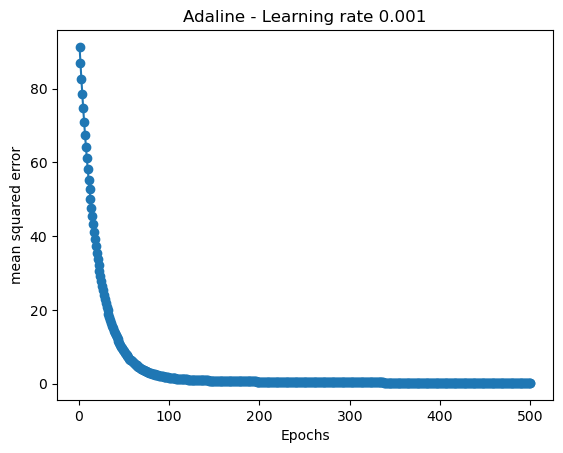

In [40]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(ada._losses) + 1),ada._losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('mean squared error')
plt.title('Adaline - Learning rate 0.001')
plt.show()

Without standardization of the features, we only achieve an accuracy slightly better than guessing. We can see that, unfortunately, the losses increase over time. In fact, they become so large that we plot the log of the losses above! Fortunately, there are steps we can take to improve the gradient descent algorithm we employed above.

Standardizing the features yields an accuracy of just under $80\%$ with $500$ iterations. While this is good, we can try to do better by employing stochastic gradient descent, where instead of updating the weights based on the sum of the errors over every observation in the training set, we instead instead update the weights based on one randomly selected observation in the training set at a time. So, for each individual weight $w_j$ and the bias $b$, we have the updates 
\begin{align*}
\Delta w_j&=\eta\left(y^{(i)}-\sigma\left(z^{(i)}\right) \right)x_j^{(i)}\\
\Delta b&=\eta\left(y^{(i)}-\sigma\left(z^{(i)}\right) \right)
\end{align*}
where $\eta$ is the learning rate.

Because of the frequent weight updates, stochastic gradient descent tends to converge much faster than full-batch gradient descent; however, it only converges to an area close to the global minimum due to the randomness inherent in the weight updates. As a result, we often pair stochastic gradient descent with an *adaptive learning rate*, meaning that the learning rate decreases with the number of iterations. Formally, if $i$ represents the number of iterations, we have
$$
\eta(i)=\frac{\eta_0}{i+c}
$$
where $\eta_0$ is the initial learning rate and $c$ is some constant which controls the rate at which the learning rate changes.

We implement a version of the Adaline model using stochastic gradient descent below.

In [12]:
class AdalineSGD():
    c=10 #this sets the value of the constant c which controls the adaptive learning rate
    
    def __init__(self, eta0=0.01, n_iter=10, random_state=1):
        self.current_iter = 0.0
        self.eta0 = eta0
        self.n_iter = n_iter
        self.random_state = random_state
        self.w_initialized = False #do this to ensure we only initialize weights once
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self._losses = []
        
        for i in range(self.n_iter):
            #have to permute X and y each epoch to prevent cycles
            X, y = self._shuffle(X, y)
            
            #keep track of average loss for each epoch
            losses = []
            for x, yi in zip(X, y):
                losses.append(self._update_weights(x, yi))
            avg_loss = np.mean(losses)
            self._losses.append(avg_loss)
            
        return self
    
    def partial_fit(self, X, y):
        '''
        The point of this method is if we want to fit the model to new data without 
        re-initializing the weights. For example, if we want to train some model
        on new data at regular intervals, such as every day, we can simply call
        partial_fit() on the new data rather than having to aggregate the new data 
        with the old data and then training a new model from scratch.
        '''
        if not self.w_initialized:
            self._initialize_weights(X,shape[1])
            
        if y.ravel().shape[0] > 1:
            for x, yi in zip(X, y):
                self._update_weights(x, yi)
        else:
            self._update_weights(X, y)
        
        return self
    
    def _initialize_weights(self, m):
        self.prng = np.random.RandomState(self.random_state)
        self._w = self.prng.normal(loc=0.0, scale=0.01, size=m)
        self._b = float(0)
        self.w_initialized = True
    
    def _shuffle(self, X, y):
        perm = self.prng.permutation(len(y))
        return X[perm], y[perm]
    
    def _update_weights(self, x, yi):
        output = self.activation(self.net_input(x))
        error = yi - output
        self.eta = self.eta0/(self.current_iter + self.c) #adaptive learning rate
        self._w += self.eta * 2.0 * x * error
        self._b += self.eta * 2.0 * error
        self.current_iter += 1.0
        
        loss = error**2
        return loss
    
    def net_input(self, X):
        return np.dot(X, self._w) + self._b
    
    def activation(self, X):
        #again we just have the identity function for now
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X))>=0.5, 1, 0)
    
    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.sum(predictions == y) / y.shape[0]
        return accuracy

Now we train the model on the training data, and test it on the test data. Hopefully, this model will converge signficantly faster than full-batch gradient descent.

In [28]:
adas = AdalineSGD(eta0=0.1, n_iter=50)
adas.fit(train_features, train_classes)

#and output the accuracy
adas.evaluate(test_features, test_classes)

0.9649122807017544

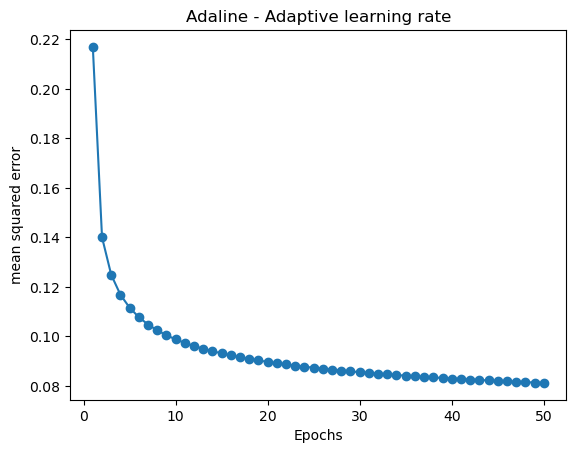

In [30]:
plt.plot(range(1, len(adas._losses) + 1),adas._losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('mean squared error')
plt.title('Adaline - Adaptive learning rate')
plt.show()

Observe that we only require $50$ iterations to converge to a much better accuracy than we were able to achieve after $500$ iterations of the full-batch gradient descent!